In [44]:
import pandas as pd
import os
import numpy as np

In [45]:
trace_dir = "/home/l/lungboy/tadam/scratch/Moshovos/ANS_NeuralComp/trace/"

In [63]:
models = os.listdir(trace_dir)
# get rid of the non-directories
models = [m for m in models if os.path.isdir(trace_dir + m)]

file_names = [
    "stats_activations_apack_8.csv",
    "stats_weights_apack_8.csv",
    "stats_activations_256_8.csv",
    "stats_weights_256_8.csv"
]
models, file_names

(['resnet18',
  'gpt2-xl',
  'inception_v3',
  'googlenet',
  'mobilenet_v2',
  'resnet50',
  'resnext101_32x8d',
  'mobilenet_v3_large',
  'shufflenet_v2_x0_5'],
 ['stats_activations_apack_8.csv',
  'stats_weights_apack_8.csv',
  'stats_activations_256_8.csv',
  'stats_weights_256_8.csv'])

In [64]:
# Dictionary to hold the DataFrames
data_frames = {}

# Iterate through directories and file names
for directory in models:
    # check if it is a directory
    if not os.path.isdir(f"{trace_dir}{directory}"):
        continue
    
    print(directory)
    key = f"{trace_dir}{directory}/"
    data_frames[key] = {"APack": {"activations": [], "weights": []}, "256": {"activations": [], "weights": []}}
    
    for file_name in file_names:
        method = "APack" if "apack" in file_name else "256"
        
        if "activations" in file_name:
            # check if gpt2-xl
            if "gpt2-xl" in directory:
                continue
            
            # check if the file exists
            if os.path.exists(f"{trace_dir}{directory}/{file_name}"):
                data_frames[key][method]["activations"] = list(pd.read_csv(f"{trace_dir}{directory}/{file_name}", usecols=["Compression Ratio"])["Compression Ratio"])
            else:
                file_name = file_name.split(".")[0] + "_8.csv"
                data_frames[key][method]["activations"] = list(pd.read_csv(f"{trace_dir}{directory}/{file_name}", usecols=["Compression Ratio"])["Compression Ratio"])
        else:
            if os.path.exists(f"{trace_dir}{directory}/{file_name}"):
                data_frames[key][method]["weights"] = list(pd.read_csv(f"{trace_dir}{directory}/{file_name}", usecols=["Compression Ratio"])["Compression Ratio"])
            else:
                file_name = file_name.split(".")[0] + "_8.csv"
                data_frames[key][method]["weights"] = list(pd.read_csv(f"{trace_dir}{directory}/{file_name}", usecols=["Compression Ratio"])["Compression Ratio"])


resnet18
gpt2-xl
inception_v3
googlenet
mobilenet_v2
resnet50
resnext101_32x8d
mobilenet_v3_large
shufflenet_v2_x0_5


In [65]:
data_frames[f"{trace_dir}shufflenet_v2_x0_5/"], data_frames[f"{trace_dir}mobilenet_v2/"]

({'APack': {'activations': [1.1794375566044617,
    1.1794375566044617,
    1.872643320243997,
    1.872643320243997,
    1.539212190811159,
    1.539212190811159,
    1.534853690706871,
    1.534853690706871,
    1.5723438011279451,
    1.5723438011279451,
    1.658306897361364,
    1.658306897361364,
    4.955434740628864,
    3.605914896209189,
    1.4779318049503374],
   'weights': [1.0273483947681332,
    1.0328750747160789,
    1.3165714285714285,
    1.2142292490118578,
    1.0128956623681125,
    1.148554336989033,
    1.0893617021276596,
    1.1242680546519193,
    1.099236641221374,
    1.0786516853932584,
    1.0806754221388368,
    1.1100939532642735,
    1.159536990437846,
    1.064039408866995,
    1.1665822784810127,
    1.0194690265486726,
    1.1393954379674849,
    1.1710292249047014,
    1.016470588235294,
    1.1537305958938409,
    1.1375671172005184,
    1.1080474511061238,
    1.1527925448746013,
    1.101535887169067,
    1.1279373368146215,
    1.11069599276890

# Baseline APack

In [66]:
import os
import re

def parse_comp(filename):
    with open(filename, "r") as f:
        # read the string
        data = f.read()
    return float(data)

def parse_directory(directory, act_pattern, act_range, w_pattern, w_range):
    """
    Parses the activation and weight .comp files in a given directory.

    Parameters:
    - directory (str): The path to the directory containing the .comp files.
    - act_pattern (str): The filename pattern for activation files, with a placeholder for the index.
    - act_range (range): The range of indices for activation files.
    - w_pattern (str): The filename pattern for weight files, with a placeholder for the index.
    - w_range (range): The range of indices for weight files.

    Returns:
    - act_list (list): A list of parsed activation values.
    - w_list (list): A list of parsed weight values.
    """
    act_list = []
    w_list = []
    
    # Iterate through the range for activation files
    for i in act_range:
        # Construct the file path and parse the .comp file
        act_list.append(parse_comp(os.path.join(directory, act_pattern.format(i))))
        
    # Iterate through the range for weight files
    for i in w_range:
        # Construct the file path and parse the .comp file
        w_list.append(parse_comp(os.path.join(directory, w_pattern.format(i))))
    
    return act_list, w_list

def calculate_ranges(directory, act_pattern, w_pattern):
    """
    Calculates the ranges for activation and weight files in a given directory.

    Parameters:
    - directory (str): The path to the directory containing the .comp files.
    - act_pattern (str): The filename pattern for activation files, with a placeholder for the index.
    - w_pattern (str): The filename pattern for weight files, with a placeholder for the index.

    Returns:
    - act_range (range): The range of indices for activation files.
    - w_range (range): The range of indices for weight files.
    """
    act_indices = []
    w_indices = []
    
    act_regex = re.compile(act_pattern.replace("{}", r"(\d+)"))
    w_regex = re.compile(w_pattern.replace("{}", r"(\d+)"))
    
    for filename in os.listdir(directory):
        act_match = act_regex.match(filename)
        if act_match:
            act_indices.append(int(act_match.group(1)))
        
        w_match = w_regex.match(filename)
        if w_match:
            w_indices.append(int(w_match.group(1)))
    
    if act_indices:
        act_range = range(min(act_indices), max(act_indices) + 1)
    else:
        act_range = range(0)
        
    if w_indices:
        w_range = range(min(w_indices), max(w_indices) + 1)
    else:
        w_range = range(0)
    
    return act_range, w_range

def generate_directories_info(directories, act_pattern, w_pattern):
    """
    Generates a dictionary containing directory information for parsing.

    Parameters:
    - directories (list of str): List of directory paths.
    - act_pattern (str): The filename pattern for activation files.
    - w_pattern (str): The filename pattern for weight files.

    Returns:
    - directories_info (dict): A dictionary with directory paths as keys and 
                               file patterns and ranges as values.
    """
    directories_info = {}
    
    for directory in directories:
        act_range, w_range = calculate_ranges(directory, act_pattern, w_pattern)
        directories_info[directory] = {
            "act_pattern": act_pattern,
            "act_range": act_range,
            "w_pattern": w_pattern,
            "w_range": w_range
        }
    
    return directories_info

# Example usage
directories = [f"{trace_dir}{model}/" for model in models]

# prune out the models that are not directories
directories = [directory for directory in directories if os.path.isdir(directory)]

act_pattern = "input_{}_flat.comp"
w_pattern = "weight_{}_flat.comp"

directories_info = generate_directories_info(directories, act_pattern, w_pattern)

# Dictionary to hold the parsed data
comp_data = {}

# Iterate through directories and parse .comp files
for directory, info in directories_info.items():
    act_list, w_list = parse_directory(
        directory, 
        info["act_pattern"], 
        info["act_range"], 
        info["w_pattern"], 
        info["w_range"]
    )
    comp_data[directory] = {
        "activations": act_list,
        "weights": w_list
    }

In [67]:
comp_data.keys()

dict_keys(['/home/l/lungboy/tadam/scratch/Moshovos/ANS_NeuralComp/trace/resnet18/', '/home/l/lungboy/tadam/scratch/Moshovos/ANS_NeuralComp/trace/gpt2-xl/', '/home/l/lungboy/tadam/scratch/Moshovos/ANS_NeuralComp/trace/inception_v3/', '/home/l/lungboy/tadam/scratch/Moshovos/ANS_NeuralComp/trace/googlenet/', '/home/l/lungboy/tadam/scratch/Moshovos/ANS_NeuralComp/trace/mobilenet_v2/', '/home/l/lungboy/tadam/scratch/Moshovos/ANS_NeuralComp/trace/resnet50/', '/home/l/lungboy/tadam/scratch/Moshovos/ANS_NeuralComp/trace/resnext101_32x8d/', '/home/l/lungboy/tadam/scratch/Moshovos/ANS_NeuralComp/trace/mobilenet_v3_large/', '/home/l/lungboy/tadam/scratch/Moshovos/ANS_NeuralComp/trace/shufflenet_v2_x0_5/'])

In [68]:
data_frames.keys()

dict_keys(['/home/l/lungboy/tadam/scratch/Moshovos/ANS_NeuralComp/trace/resnet18/', '/home/l/lungboy/tadam/scratch/Moshovos/ANS_NeuralComp/trace/gpt2-xl/', '/home/l/lungboy/tadam/scratch/Moshovos/ANS_NeuralComp/trace/inception_v3/', '/home/l/lungboy/tadam/scratch/Moshovos/ANS_NeuralComp/trace/googlenet/', '/home/l/lungboy/tadam/scratch/Moshovos/ANS_NeuralComp/trace/mobilenet_v2/', '/home/l/lungboy/tadam/scratch/Moshovos/ANS_NeuralComp/trace/resnet50/', '/home/l/lungboy/tadam/scratch/Moshovos/ANS_NeuralComp/trace/resnext101_32x8d/', '/home/l/lungboy/tadam/scratch/Moshovos/ANS_NeuralComp/trace/mobilenet_v3_large/', '/home/l/lungboy/tadam/scratch/Moshovos/ANS_NeuralComp/trace/shufflenet_v2_x0_5/'])

In [69]:
# append comp_data to data_frames
for key in comp_data:
    data_frames[key]["comp"] = comp_data[key]

# Weights

In [70]:
import numpy as np

In [71]:
# get means of data_frames
for key in data_frames:
    data_frames[key]["APack"]["activations_mean"] = np.mean(data_frames[key]["APack"]["activations"])
    data_frames[key]["APack"]["weights_mean"] = np.mean(data_frames[key]["APack"]["weights"])
    data_frames[key]["256"]["activations_mean"] = np.mean(data_frames[key]["256"]["activations"])
    data_frames[key]["256"]["weights_mean"] = np.mean(data_frames[key]["256"]["weights"])
    data_frames[key]["comp"]["activations_mean"] = np.mean(data_frames[key]["comp"]["activations"])
    data_frames[key]["comp"]["weights_mean"] = np.mean(data_frames[key]["comp"]["weights"])


/scinet/niagara/software/2019b/opt/base/python/3.11.5/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/scinet/niagara/software/2019b/opt/base/python/3.11.5/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [72]:
for model in models:
    print(len([data_frames[f"{trace_dir}{model}/"]["APack"]["activations_mean"], data_frames[f"{trace_dir}{model}/"]["APack"]["weights_mean"], data_frames[f"{trace_dir}{model}/"]["256"]["activations_mean"], data_frames[f"{trace_dir}{model}/"]["256"]["weights_mean"], data_frames[f"{trace_dir}{model}/"]["comp"]["activations_mean"], data_frames[f"{trace_dir}{model}/"]["comp"]["weights_mean"]]))

6
6
6
6
6
6
6
6
6


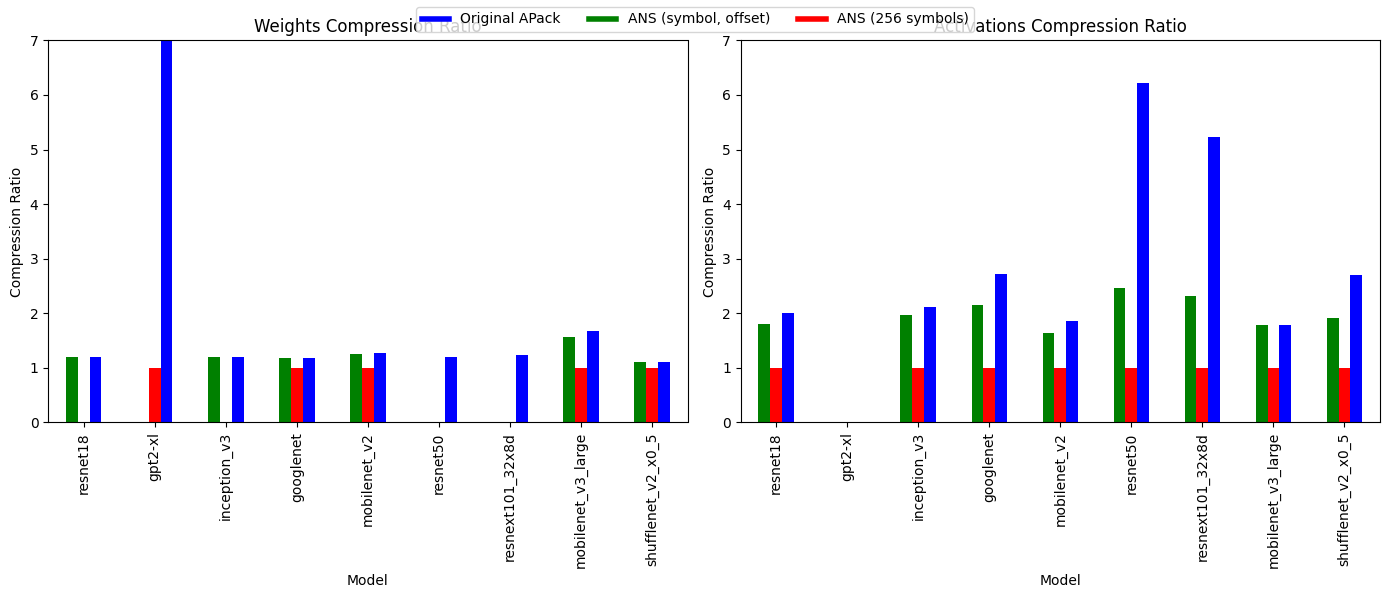

In [75]:
import matplotlib.pyplot as plt

# Create DataFrames
df_w = pd.DataFrame({
    "Model": models,
    "w_apack": [data_frames[key]["APack"]["weights_mean"] for key in data_frames],
    "w_256": [data_frames[key]["256"]["weights_mean"] for key in data_frames],
    "w_orig": [data_frames[key]["comp"]["weights_mean"] for key in data_frames]
})

df_act = pd.DataFrame({
    "Model": models,
    "act_apack": [data_frames[key]["APack"]["activations_mean"] for key in data_frames],
    "act_256": [data_frames[key]["256"]["activations_mean"] for key in data_frames],
    "act_orig": [data_frames[key]["comp"]["activations_mean"] for key in data_frames]
})

# Define the colors for each category
color_map = {
    "Original APack": "blue",
    "ANS (symbol, offset)": "green",
    "ANS (256 symbols)": "red"
}

# Define the figure and subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plot weights compression ratio
bars_w = df_w.set_index("Model").plot(kind="bar", ax=axs[0], color=[color_map["ANS (symbol, offset)"], color_map["ANS (256 symbols)"], color_map["Original APack"]], legend=False)
axs[0].set_title("Weights Compression Ratio")
axs[0].set_ylabel("Compression Ratio")
axs[0].set_ylim([0,7])  # Set y-axis limits to zoom in

# Plot activations compression ratio
bars_act = df_act.set_index("Model").plot(kind="bar", ax=axs[1], color=[color_map["ANS (symbol, offset)"], color_map["ANS (256 symbols)"], color_map["Original APack"]], legend=False)
axs[1].set_title("Activations Compression Ratio")
axs[1].set_ylabel("Compression Ratio")
axs[1].set_ylim([0, 7])  # Set y-axis limits to zoom in

# Add legend
handles = [plt.Line2D([0], [0], color=color_map[key], lw=4) for key in ["Original APack", "ANS (symbol, offset)", "ANS (256 symbols)"]]
fig.legend(handles, color_map.keys(), loc="upper center", ncol=3)

# Improve layout
plt.tight_layout()

# Display the plot
plt.show()

In [ ]:
df_act

,Model,act_apack,act_256,act_orig
0,mobilenet_v2,1.646724,1.151465,1.855171
1,mobilenet_v3_large,1.816063,1.411771,1.777415
2,shufflenet_v2_x0_5,1.916858,0.999679,2.707016


In [ ]:
# Compute how much the compression ratio has improved with APack
print("APack/comp")
for key in data_frames:
    print(f"\t{key}:")
    print("\t\tweights:", data_frames[key]["APack"]["weights_mean"] / data_frames[key]["comp"]["weights_mean"]) 
    print("\t\tactivations",data_frames[key]["APack"]["activations_mean"] / data_frames[key]["comp"]["activations_mean"])
    
# Compute how much the compression ratio has improved with 256
print("Apack/256")
for key in data_frames:
    print(f"\t{key}:")
    print("\t\tweights:", data_frames[key]["APack"]["weights_mean"] / data_frames[key]["256"]["weights_mean"]) 
    print("\t\tactivations",data_frames[key]["APack"]["activations_mean"] / data_frames[key]["256"]["activations_mean"])

APack/comp
	trace/mobilenet_v2/:
		weights: 0.9963855822041271
		activations 0.8900037821313149
	trace/mobilenet_v3_large/:
		weights: 0.9355709130537646
		activations 1.0140085428881394
Apack/256
	trace/mobilenet_v2/:
		weights: 1.0266185070587148
		activations 1.4301124392021782
	trace/mobilenet_v3_large/:
		weights: 1.1328550879059367
		activations 1.286372161084841
